# STORM 개념을 도입한 연구를 위한 멀티 에이전트

이 튜토리얼의 목적은 LangGraph를 활용하여 연구 자동화 시스템을 구축하는 방법에 대해서 다룹니다. 

연구는 종종 분석가에게 위임되는 노동 집약적인 작업입니다. AI는 이러한 연구 과정을 지원할 수 있는 상당한 잠재력을 가지고 있습니다. 이 튜토리얼에서는 사용자 맞춤형 AI 기반 연구 및 보고서 생성 워크플로우를 구축하는 방법을 다룹니다.

이번 튜토리얼에서는 경량의 다중 에이전트 시스템을 구축하여 연구 과정을 맞춤화하는 것을 목표로 합니다. 사용자는 연구 주제를 제공하고, 시스템은 각 하위 주제에 집중하는 AI 분석가 팀을 생성합니다. 

이 과정에서 `Human-in-the-loop`를 사용하여 연구가 시작되기 전에 하위 주제를 세분화합니다.

[STORM 논문](https://arxiv.org/abs/2402.14207)에 따르면, **유사한 주제 조회**와 **다양한 관점의 대화 시뮬레이션**을 통해 참고 출처 사용 빈도와 정보 밀도를 증가시킬 수 있습니다. 

**주로 다루는 내용**
- **LangGraph의 주요 테마**: Memory, Human-in-the-loop, Controllability
- **연구 자동화의 목표**: 사용자 맞춤형 연구 프로세스 구축
- **소스 선택**: 연구를 위한 입력 소스 선택
- **계획**: 주제 제공 및 AI 분석가 팀 생성
- **LLM 활용**: 전문가 AI와의 심층 인터뷰
- **연구 과정**: 병렬로 정보 수집 및 인터뷰 수행
- **출력 형식**: 최종 보고서로 통합된 통찰력
- **설정**: 환경 설정 및 API 키 설정
- **분석가 생성**: Human-In-The-Loop를 통한 분석가 생성 및 검토
- **인터뷰 수행**: 질문 생성 및 답변 수집
- **병렬 인터뷰**: Map-Reduce를 통한 인터뷰 병렬화
- **최종 보고서 작성**: 보고서의 서론 및 결론 작성

이번 튜토리얼에서는 다음의 세 가지 테마를 다룹니다.

- **Memory**
- **Human-in-the-loop**
- **Controllability**

이제 이러한 개념을 결합하여 AI의 가장 인기 있는 응용 분야 중 하나인 연구 자동화를 다루겠습니다. 

연구는 종종 분석가에게 위임되는 노동 집약적인 작업입니다. AI는 이러한 연구 과정을 지원할 수 있는 상당한 잠재력을 가지고 있습니다. 그러나 연구는 맞춤화가 필요합니다. 원시 LLM 출력은 실제 의사 결정 워크플로우에 적합하지 않은 경우가 많습니다.

맞춤형 AI 기반 [연구 및 보고서 생성](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) 워크플로우는 이를 해결할 수 있는 유망한 방법입니다.

![langgraph-storm-concept](./assets/langgraph-storm-concept.png)

## 환경 설정

In [38]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [39]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


In [40]:
from langchain_teddynote.models import get_model_name, LLMs
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

# 최신 모델 가져오기
GPT4o = get_model_name(LLMs.GPT4o)

model_name = "gemini-2.0-flash"

# 모델 초기화
llm = ChatGoogleGenerativeAI(model=model_name)

## 분석가 생성: Human-In-The-Loop

- **분석가 생성**: `Human-In-The-Loop`를 활용하여 분석가를 생성하고 검토합니다.

In [69]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_teddynote.graphs import visualize_graph
from dataclasses import dataclass


# 분석가의 속성과 메타데이터를 정의하는 클래스
class Analyst(BaseModel):
    # 주요 소속 정보
    affiliation: str = Field(None,
        description="Primary affiliation of the analyst.",
    )
    # 이름
    name: str = Field(None,description="Name of the analyst.")

    # 역할
    role: str = Field(None,
        description="Role of the analyst in the context of the topic.",
    )
    # 중점, 우려 사항 및 동기에 대한 설명
    description: str = Field(None,
        description="Description of the analyst focus, concerns, and motives.",
    )

    # 분석가의 인적 정보를 문자열로 반환하는 속성
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


# 분석가들의 집합
class Perspectives(BaseModel):
    # 분석가 목록
    analysts: List[Analyst] = Field(default_factory=list,
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

다음은 Analyst 클래스를 통해 생성된 분석가들의 집합을 추적하는 상태를 정의합니다.

In [70]:
# 상태 정의
class GenerateAnalystsState(TypedDict):
    # 연구 주제
    topic: str
    # 생성할 분석가의 최대 수
    max_analysts: int
    # 사람 피드백
    human_analyst_feedback: str
    # 분석가 목록
    analysts: List[Analyst]

## 분석가(Analyst) 생성 노드 정의

다음으로는 분석가(Analyst) 생성 노드를 정의하겠습니다.

아래 코드는 주어진 연구 주제에 대해 다양한 분석가를 생성하는 로직을 구현합니다. 각 분석가는 고유한 역할과 소속을 가지며, 주제에 대한 전문적인 관점을 제공합니다.

In [71]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage, SystemMessage

# 분석가 생성 프롬프트
# analyst_instructions = """You are tasked with creating a set of AI analyst personas. 

# Follow these instructions carefully:
# 1. First, review the research topic:

# {topic}
        
# 2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
# {human_analyst_feedback}
    
# 3. Determine the most interesting themes based upon documents and / or feedback above.
                    
# 4. Pick the top {max_analysts} themes.

# 5. Assign one analyst to each theme. For each analyst, you must define their name, role, affiliation, and a detailed description of their focus, concerns, and motives.

# 6. The affiliation should be a short string, and the description should be a paragraph.

# """
analyst_instructions = """You are tasked with creating a set of AI analyst personas. 

Follow these instructions carefully:
1. First, review the research topic:

{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


# 분석가 생성 노드
def create_analysts(state: GenerateAnalystsState):
    """분석가 페르소나를 생성하는 함수"""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # LLM에 구조화된 출력 형식을 적용
    structured_llm = llm.with_structured_output(Perspectives)

    # 분석가 생성을 위한 시스템 프롬프트 구성
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    # LLM을 호출하여 분석가 페르소나 생성
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    # 생성된 분석가 목록을 상태에 저장
    return {"analysts": analysts.analysts}


# 사용자 피드백 노드(상태 업데이트를 진행할 예정이므로, 내용은 비워 두어도 무방)
def human_feedback(state: GenerateAnalystsState):
    """사용자 피드백을 받기 위한 중단점 노드"""
    pass


# 인간 피드백 여부에 따라 워크플로우의 다음 단계를 결정하는 함수
def should_continue(state: GenerateAnalystsState):
    """워크플로우의 다음 단계를 결정하는 함수"""

    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

## 그래프 생성

이제 분석가 생성 그래프를 생성합니다.

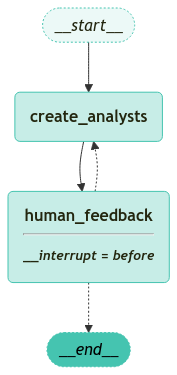

In [72]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage

# 그래프 생성
builder = StateGraph(GenerateAnalystsState)

# 노드 추가
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# 엣지 연결
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")

# 조건부 엣지 추가: 사람 피드백이 있을 경우 다시 분석가 생성 노드로 돌아갑니다.
builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# 메모리 생성
memory = MemorySaver()

# 그래프 컴파일(중단점 설정)
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# 그래프 시각화
visualize_graph(graph)

## 분석가 생성을 위한 그래프 실행

In [73]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": random_uuid()},
)

# 분석가 수 설정
max_analysts = 3

# 연구 주제 설정
topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 입력 데이터 설정
inputs = {
    "topic": topic,
    "max_analysts": max_analysts,
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation=None name='Efficiency Expert' role='Performance Analyst' description=None
affiliation=None name='Scalability Guru' role='System Architect' description=None
affiliation=None name='Customization Advocate' role='Solutions Engineer' description=None

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


`__interrupt__` 가 출력되면 인간의 피드백을 받을 준비가 된 것입니다.

이제 아래의 상태를 가져와서 인간 피드백을 제공합니다.

In [74]:
# 그래프의 현재 상태 가져오기
state = graph.get_state(config)

# 다음 실행할 노드 확인
print(state.next)

('human_feedback',)


`update_state()` 를 통해 인간 피드백을 주입합니다. 이때 `human_analyst_feedback` 키에 피드백 내용을 저장합니다.

또한 `as_node` 인자를 통해 피드백을 받을 노드를 지정합니다.

In [75]:
# 그래프 상태를 업데이트하여 human_feedback 노드의 역할 수행
graph.update_state(
    config,
    {
        "human_analyst_feedback": "Add in someone named Teddy Lee from a startup to add an entrepreneur perspective"
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': '891468a7-cd59-4239-ae06-9e11f6534d5b',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff4446-b61e-6e4c-8002-c6c28c40bd57'}}

`None` 값을 입력으로 주게 되면, 이어서 그래프가 진행됩니다.

**참고**

- 재개하고자 할 때는 입력에 `None` 값을 할당하여 그래프를 재개합니다.

In [76]:
# 이어서 진행
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation=None name='Dr. Anya Sharma' role='Academic Researcher' description=None
affiliation=None name='Kenji Tanaka' role='Lead ML Engineer' description=None
affiliation=None name='Teddy Lee' role='Startup Founder' description=None

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


다시 `__interrupt__` 가 출력되면 인간의 피드백을 받을 준비가 된 것입니다.

이전의 방식과 동일하게 다시 인간 피드백을 제공하여 생성된 분석가의 페르소나를 조정하는 것도 가능합니다.

하지만, 추가 피드백이 없을 경우 `None` 값을 할당하여 분석가 생성 작업을 종료할 수 있습니다.

In [77]:
# 추가 피드백이 없을 경우 None 값을 할당하여 상태 업데이트
human_feedback_input = None

# 그래프 상태를 업데이트하여 human_feedback 노드의 역할 수행
graph.update_state(
    config, {"human_analyst_feedback": human_feedback_input}, as_node="human_feedback"
)

{'configurable': {'thread_id': '891468a7-cd59-4239-ae06-9e11f6534d5b',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff4446-e5d9-66fa-8004-3453455b4233'}}

In [78]:
# 이어서 진행
invoke_graph(graph, None, config)

최종 결과를 출력합니다.

In [79]:
# 그래프의 최종 상태 가져오기
final_state = graph.get_state(config)

# 최종 상태에서 생성된 분석가 목록 가져오기
analysts = final_state.values.get("analysts")

# 생성된 분석가 수 출력
print(f"생성된 분석가 수: {len(analysts)}", end="\n================================\n")

# 각 분석가의 페르소나 출력
for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)

생성된 분석가 수: 3
Name: Dr. Anya Sharma
Role: Academic Researcher
Affiliation: None
Description: None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Kenji Tanaka
Role: Lead ML Engineer
Affiliation: None
Description: None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Teddy Lee
Role: Startup Founder
Affiliation: None
Description: None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


`final_state.next` 는 그래프의 다음 실행할 노드를 나타냅니다. 여기서는 모든 작업이 마무리 되었기 때문에 빈 `tuple` 이 출력됩니다.

In [80]:
# 그래프의 다음 실행할 노드 상태 가져오기
print(final_state.next)

()


## 인터뷰 수행

### 질문 생성

- 분석가는 전문가에게 질문을 제시합니다.

In [81]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


# 인터뷰 상태 정의
class InterviewState(MessagesState):
    # 대화 턴수
    max_num_turns: int
    # 소스 문서를 포함하는 컨텍스트 리스트
    context: Annotated[list, operator.add]
    # 지정된 분석가
    analyst: Analyst
    # 인터뷰 내용을 저장하는 문자열
    interview: str
    # 보고서 섹션 리스트
    sections: list


# 검색 쿼리 데이터 클래스 정의
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

다음으로는 인터뷰 질문을 생성하는 노드를 정의합니다.

In [82]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


# 질문을 생성하는 노드 정의
def generate_question(state: InterviewState):
    # 상태에서 분석가와 메시지 가져오기
    analyst = state["analyst"]
    messages = state["messages"]

    # 질문 생성
    # 분석가의 목표를 기반으로 시스템 메시지 생성
    system_message = question_instructions.format(goals=analyst.persona)
    # LLM을 사용하여 질문 생성
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 상태에 메시지 기록
    return {"messages": [question]}

## 도구 정의

전문가는 여러 소스로부터 정보를 병렬로 수집하여 질문에 답변합니다.

웹 문서 스크래핑, VectorDB, 웹 검색, 위키피디아 검색 등 다양한 도구를 사용할 수 있습니다.

이 튜토리얼에서는 Arxiv, Tavily 검색을 사용합니다.

In [83]:
# 웹 검색 도구 초기화
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색을 위한 TavilySearch 인스턴스 생성
tavily_search = TavilySearch(max_results=3)

In [84]:
from langchain_community.retrievers import ArxivRetriever

# Arxiv 검색을 위한 ArxivRetriever 인스턴스 생성
arxiv_retriever = ArxivRetriever(
    load_max_docs=3,
    load_all_available_meta=True,
    get_full_documents=True,
)

# 검색 결과 출력
arxiv_search_results = arxiv_retriever.invoke("Modular RAG vs Naive RAG")
print(arxiv_search_results)

[Document(metadata={'Published': '2024-07-26', 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks', 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang', 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a high

In [85]:
# Arxiv 메타데이터 출력
arxiv_search_results[0].metadata

{'Published': '2024-07-26',
 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks',
 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang',
 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a highly reconfigurabl

In [86]:
# Arxiv 내용 출력
print(arxiv_search_results[0].page_content)

1
Modular RAG: Transforming RAG Systems into
LEGO-like Reconfigurable Frameworks
Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang
Abstract—Retrieval-augmented
Generation
(RAG)
has
markedly enhanced the capabilities of Large Language Models
(LLMs) in tackling knowledge-intensive tasks. The increasing
demands of application scenarios have driven the evolution
of RAG, leading to the integration of advanced retrievers,
LLMs and other complementary technologies, which in turn
has amplified the intricacy of RAG systems. However, the rapid
advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process
of “retrieve-then-generate”. In this context, this paper examines
the limitations of the existing RAG paradigm and introduces
the modular RAG framework. By decomposing complex RAG
systems into independent modules and specialized operators, it
facilitates a highly reconfigurable framework. Modular RAG
transcends the traditional linear architect

문서 검색결과를 포맷팅 출력합니다.

In [87]:
# 문서 검색 결과를 포맷팅
formatted_search_docs = "\n\n---\n\n".join(
    [
        f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
        for doc in arxiv_search_results
    ]
)

In [88]:
print(formatted_search_docs)

<Document source="http://arxiv.org/abs/2407.21059v1" date="2024-07-26" authors="Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang"/>
<Title>
Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks
</Title>

<Summary>
Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities
of Large Language Models (LLMs) in tackling knowledge-intensive tasks. The
increasing demands of application scenarios have driven the evolution of RAG,
leading to the integration of advanced retrievers, LLMs and other complementary
technologies, which in turn has amplified the intricacy of RAG systems.
However, the rapid advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process of
"retrieve-then-generate". In this context, this paper examines the limitations
of the existing RAG paradigm and introduces the modular RAG framework. By
decomposing complex RAG systems into independent modules and specialized
operators, it fa

## 노드 생성


In [89]:
from langchain_core.messages import get_buffer_string
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

# 검색 쿼리 작성
search_instructions = SystemMessage(
    content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query"""
)


# 웹 검색 수행 함수 정의
def search_web(state: InterviewState):
    """웹 검색을 통한 문서 검색"""

    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # 검색 수행
    search_docs = tavily_search.invoke(search_query.search_query)

    # 검색 결과 형식 지정
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


# Arxiv 검색 노드 생성
def search_arxiv(state: InterviewState):
    """Arxiv 검색 노드"""

    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    try:
        # 검색 수행
        arxiv_search_results = arxiv_retriever.invoke(
            search_query.search_query,
            load_max_docs=2,
            load_all_available_meta=True,
            get_full_documents=True,
        )

        # 검색 결과 형식 지정
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
                for doc in arxiv_search_results
            ]
        )

        return {"context": [formatted_search_docs]}
    except Exception as e:
        print(f"Arxiv 검색 중 오류 발생: {str(e)}")
        return {
            "context": ["<Error>Arxiv 검색 결과를 가져오는데 실패했습니다.</Error>"]
        }


answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""


# 질문에 대한 답변 생성 함수 정의
def generate_answer(state: InterviewState):
    """질문에 대한 답변 생성 노드"""

    # 상태에서 분석가와 메시지 가져오기
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # 질문에 대한 답변 생성
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 메시지를 전문가의 답변으로 명명
    answer.name = "expert"

    # 상태에 메시지 추가
    return {"messages": [answer]}


# 인터뷰 저장 함수 정의
def save_interview(state: InterviewState):
    """인터뷰 저장"""

    # 메시지 가져오기
    messages = state["messages"]

    # 인터뷰를 문자열로 변환
    interview = get_buffer_string(messages)

    # 인터뷰 키에 저장
    return {"interview": interview}


# 메시지 라우팅 함수 정의
def route_messages(state: InterviewState, name: str = "expert"):
    """질문과 답변 사이의 라우팅"""

    # 메시지 가져오기
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # 전문가의 답변 수 확인
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # 전문가가 최대 턴 수 이상 답변한 경우 종료
    if num_responses >= max_num_turns:
        return "save_interview"

    # 이 라우터는 각 질문-답변 쌍 후에 실행됨
    # 논의 종료를 신호하는 마지막 질문 가져오기
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"


# 세션 작성 지시사항
section_writer_instructions = """You are an expert technical writer. 

Your task is to create a detailed and comprehensive section of a report, thoroughly analyzing a set of source documents.
This involves extracting key insights, elaborating on relevant points, and providing in-depth explanations to ensure clarity and understanding. Your writing should include necessary context, supporting evidence, and examples to enhance the reader's comprehension. Maintain a logical and well-organized structure, ensuring that all critical aspects are covered in detail and presented in a professional tone.

Please follow these instructions:
1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Comprehensive analysis (### header)
d. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. For the Comprehensive analysis section:
- Provide a detailed examination of the information from the source documents.
- Break down complex ideas into digestible segments, ensuring a logical flow of ideas.
- Use sub-sections where necessary to cover multiple perspectives or dimensions of the analysis.
- Support your analysis with data, direct quotes, and examples from the source documents.
- Clearly explain the relevance of each point to the overall focus of the report.
- Use bullet points or numbered lists for clarity when presenting multiple related ideas.
- Ensure the tone remains professional and objective, avoiding bias or unsupported opinions.
- Aim for at least 800 words to ensure the analysis is thorough.

7. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

8. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
9. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


# 섹션 작성 함수 정의
def write_section(state: InterviewState):
    """질문에 대한 답변 생성 노드"""

    # 상태에서 컨텍스트, 분석가 가져오기
    context = state["context"]
    analyst = state["analyst"]

    # 섹션 작성을 위한 시스템 프롬프트 정의
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )

    # 상태에 섹션 추가
    return {"sections": [section.content]}

## 인터뷰 그래프 생성

인터뷰를 수행하는 그래프를 정의하고 실행합니다.

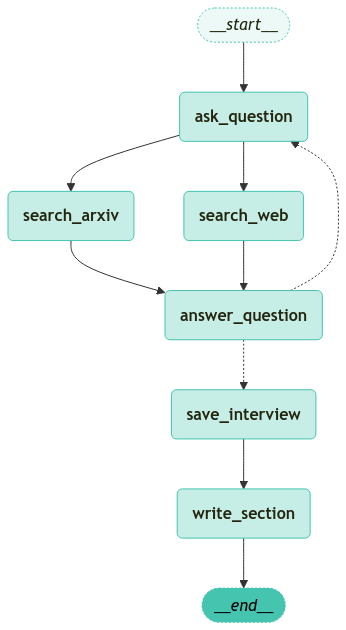

In [90]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 노드 및 엣지 추가
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_arxiv", search_arxiv)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# 흐름 설정
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_arxiv")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_arxiv", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# 인터뷰 그래프 생성
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(
    run_name="Conduct Interviews"
)

# 그래프 시각화
visualize_graph(interview_graph)

In [91]:
# 분석가 목록에서 첫 번째 분석가 선택
analysts[0]

Analyst(affiliation=None, name='Dr. Anya Sharma', role='Academic Researcher', description=None)

## 그래프 실행

이제 그래프를 실행하고 결과를 출력합니다.

In [92]:
from IPython.display import Markdown

# 주제 설정
topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 인터뷰 시작 메시지 생성
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

# 스레드 ID 설정
config = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": random_uuid()},
)

# 그래프 실행
invoke_graph(
    interview_graph,
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 100},
    config,
)


🔄 Node: ask_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Okay, Dr. Sharma, thank you for your time today. My name is David Chen, and I'm an analyst looking to get a better grasp of the nuances between "naive" and "modular" RAG systems, especially concerning their practical advantages in production environments.

You mentioned you're writing an article on this. To start, could you elaborate on what you consider to be the defining characteristics that differentiate a "naive" RAG implementation from a "modular" one? What are the key architectural differences we're talking about here?

🔄 Node: search_web 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<Document href="https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/"/>
Naive RAG, the initial implementation of Retrieval-Augmented Generation, operates on a straightforward principle: retrieve relevant documents from an extern

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 Unable to submit request because it has an empty text parameter. Add a value to the parameter and try again. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini

마크다운 형식으로 결과를 출력합니다.

In [67]:
# 완성된 인터뷰 섹션 출력
Markdown(interview_graph.get_state(config).values["sections"][0])

KeyError: 'sections'

In [ ]:
print(interview_graph.get_state(config).values["sections"][0])

## 인터뷰를 병렬로 진행 (map-reduce)

- 인터뷰는 langgraph 의 `Send()` 함수를 사용하여 병렬화하며, 이는 `map` 단계에 해당합니다.
- 인터뷰 결과는 `reduce` 단계에서 보고서 본문에 통합됩니다.
- 최종 보고서에 서론과 결론을 작성하는 마지막 단계를 추가합니다.

In [35]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


# ResearchGraphState 상태 정의
class ResearchGraphState(TypedDict):
    # 연구 주제
    topic: str
    # 생성할 분석가의 최대 수
    max_analysts: int
    # 인간 분석가의 피드백
    human_analyst_feedback: str
    # 질문을 하는 분석가 목록
    analysts: List[Analyst]
    # Send() API 키를 포함하는 섹션 리스트
    sections: Annotated[list, operator.add]
    # 최종 보고서의 서론
    introduction: str
    # 최종 보고서의 본문 내용
    content: str
    # 최종 보고서의 결론
    conclusion: str
    # 최종 보고서
    final_report: str

### LangGraph 의 Send() 함수 사용

아래는 langgraph 의 `Send()` 함수를 사용하여 인터뷰를 병렬로 시작하는 함수입니다.

**참고**

- [LangGraph Send()](https://langchain-ai.github.io/langgraph/concepts/low_level/#send)

In [36]:
from langgraph.constants import Send


# 모든 인터뷰를 시작
def initiate_all_interviews(state: ResearchGraphState):
    # 사람의 피드백 확인
    human_analyst_feedback = state.get("human_analyst_feedback")

    # 만약, 사람의 피드백이 있으면 분석가 생성으로 돌아가기
    if human_analyst_feedback:
        return "create_analysts"

    # 그렇지 않으면 Send() 함수를 통해 인터뷰 병렬로 시작
    else:
        topic = state["topic"]
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"So you said you were writing an article on {topic}?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]

### 보고서 작성 정의

다음은 인터뷰 내용을 바탕으로 보고서 작성 가이드라인을 정의하고 보고서 작성 함수를 정의합니다.

In [37]:
# 보고서 작성 지시사항
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.  
2. Carefully review and analyze the insights from each memo.  
3. Consolidate these insights into a detailed and comprehensive summary that integrates the central ideas from all the memos.  
4. Organize the key points from each memo into the appropriate sections provided below, ensuring that each section is logical and well-structured.  
5. Include all required sections in your report, using `### Section Name` as the header for each.  
6. Aim for approximately 250 words per section, providing in-depth explanations, context, and supporting details.  

**Sections to consider (including optional ones for greater depth):**

- **Background**: Theoretical foundations, key concepts, and preliminary information necessary to understand the methodology and results.
- **Related Work**: Overview of prior studies and how they compare or relate to the current research.
- **Problem Definition**: A formal and precise definition of the research question or problem the paper aims to address.
- **Methodology (or Methods)**: Detailed description of the methods, algorithms, models, data collection processes, or experimental setups used in the study.
- **Implementation Details**: Practical details of how the methods or models were implemented, including software frameworks, computational resources, or parameter settings.
- **Experiments**: Explanation of experimental protocols, datasets, evaluation metrics, procedures, and configurations employed to validate the methods.
- **Results**: Presentation of experimental outcomes, often with statistical tables, graphs, figures, or qualitative analyses.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""


# 보고서 작성 함수 정의
def write_report(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 최종 보고서 작성
    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Write a report based upon these memos.")]
    )
    return {"content": report.content}


# 서론과 결론 작성 지시사항
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 200 words, crisply previewing (for introduction),  or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


# 서론 작성 함수 정의
def write_introduction(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 서론 작성
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    intro = llm.invoke(
        [instructions] + [HumanMessage(content=f"Write the report introduction")]
    )
    return {"introduction": intro.content}


# 결론 작성 함수 정의
def write_conclusion(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 결론 작성
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    conclusion = llm.invoke(
        [instructions] + [HumanMessage(content=f"Write the report conclusion")]
    )
    return {"conclusion": conclusion.content}


# 최종 보고서 작성 함수 정의
def finalize_report(state: ResearchGraphState):
    # 모든 섹션을 모아 최종 보고서 작성
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = (
        state["introduction"]
        + "\n\n---\n\n## Main Idea\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

## 그래프 정의

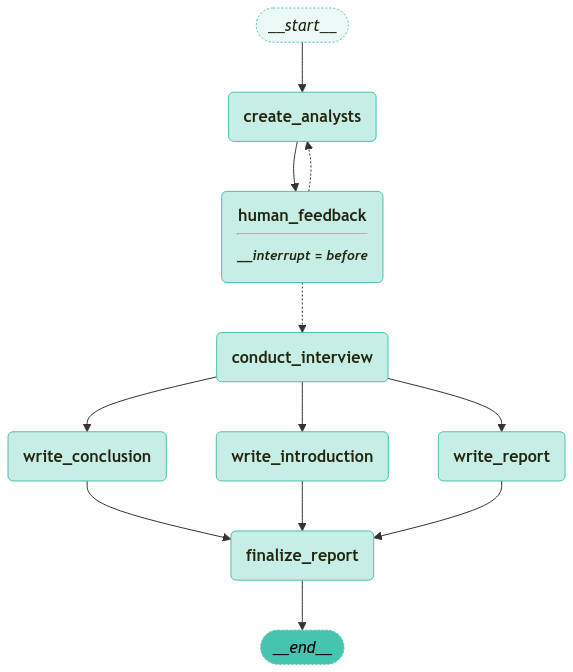

In [62]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START, END
from langchain_teddynote.graphs import visualize_graph

# 그래프 생성
builder = StateGraph(ResearchGraphState)

# 노드 정의
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# 엣지 정의
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]
)

# 인터뷰 결과 보고서 작성
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")

# 보고서 최종 정리
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"], "finalize_report"
)
builder.add_edge("finalize_report", END)

# 컴파일
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

visualize_graph(graph)

## 그래프 실행

이제 그래프를 실행하고 결과를 확인합니다.

`max_analysts`, `topic` 을 자유롭게 변경하여 실행해 보세요.

In [ ]:
# 입력 데이터 설정
max_analysts = 3
topic = "Explain how Modular RAG differs from traditional Naive RAG and the benefits of using it at the production level."

# config 설정
config = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": random_uuid()},
)

# 입력 데이터 설정
inputs = {"topic": topic, "max_analysts": max_analysts}

# 그래프 실행: 첫 번째 중단 지점까지
invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation=None name='Dr. Anya Sharma' role='RAG Architecture Specialist' description=None
affiliation=None name='Ben Carter' role='Production Engineer' description=None
affiliation=None name='Elena Rodriguez' role='Data Quality Analyst' description=None

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


human_feedback 을 추가하여 분석가를 설정합니다.

In [29]:
# 새로운 분석가 추가
graph.update_state(
    config,
    {"human_analyst_feedback": "Add Prof. Jeffrey Hinton as a head of AI analyst"},
    as_node="human_feedback",
)

{'configurable': {'thread_id': '95ec65fe-ad79-45e4-8c0b-3d714553b537',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff4435-2398-6c46-8002-22dd0b1b055b'}}

In [ ]:
# 그래프 실행
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation=None name='Prof. Jeffrey Hinton' role='Head of AI Analyst' description=None
affiliation=None name='RAG Deep Dive Analyst' role='Expert in RAG architectures' description=None
affiliation=None name='Production Implementation Analyst' role='Focuses on the practical aspects of deploying RAG systems' description=None

🔄 Node: __interrupt__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


이제 사람의 피드백을 종료하고 그래프를 재개합니다.

In [31]:
# 그래프 재개
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '95ec65fe-ad79-45e4-8c0b-3d714553b537',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff4435-5973-6cb2-8004-f1cddb18c2ec'}}

In [ ]:
# 그래프 실행
invoke_graph(graph, None, config)

최종 완성된 보고서를 출력합니다.

In [33]:
from IPython.display import Markdown

# 그래프의 최종 상태 가져오기
final_state = graph.get_state(config)

# 최종 보고서 가져오기
report = final_state.values.get("final_report")

# 마크다운 형식으로 최종 보고서 출력
display(Markdown(report))

<IPython.core.display.Markdown object>

In [34]:
print(report)

None
